# Setup

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [2]:


import importlib
import modules.trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_halfcheetah

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.trainer)
importlib.reload(env.custom_halfcheetah)

# Re-import the specific functions into the global namespace
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-source-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-target-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\

In [3]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

#  UDR - Half Cheetah

## Training

In [18]:


HALF_CHEETAH_CONFIG_UDR = config = {
    'env_id': 'CustomHalfCheetah-source-v0',
    'algorithm': 'SAC',
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,
    
    # DORAEMON Settings
    'use_doraemon': False,    

}

print("=== Training HalfCheetah with UDR ===")
model_udr, env_udr, _ = train_agent(HALF_CHEETAH_CONFIG_UDR, log_dir="./logs/halfcheetah/udr")


=== Training HalfCheetah with UDR ===
--- STARTING NEW TRAINING ---
Using cpu device
--- UDR Mode: Training without DORAEMON ---
Logging to ./tensorboard_logs/SAC_30
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 976      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 249      |
|    time_elapsed    | 16       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23.2    |
|    critic_loss     | 0.942    |
|    ent_coef        | 0.748    |
|    ent_coef_loss   | -2.83    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 975      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 225      |
|    time_elapsed 

In [19]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


## evaluation source VS target

In [23]:
# Run evaluation
# Define the raw environments
# # from stable_baselines3 import SAC

norm_path = f"./logs/halfcheetah/udr/final_vecnormalize.pkl"
source_env = gym.make('CustomHalfCheetah-source-v0')

target_env = gym.make('CustomHalfCheetah-target-v0')

evaluate_sim2real(model_udr, source_env, target_env, log_dir="./logs/halfcheetah/udr", model_name="final")

Loaded Normalization stats from ./logs/halfcheetah/udr/final_vecnormalize.pkl

--- Evaluating on SOURCE Env (Simulation) ---
Reward: 7771.52 +/- 56.94
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 7728.54 +/- 55.02
Length: 1000.00 +/- 0.00 steps


(np.float64(7771.517287258804), np.float64(7728.54287326932))

## Render

In [24]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3 import SAC
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/udr/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_udr_loaded = SAC.load('./logs/halfcheetah/udr/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_udr_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

Episode 1: Total Reward = 7802.55
Episode 2: Total Reward = 7763.75
Episode 3: Total Reward = 7802.61
Episode 4: Total Reward = 7794.98
Episode 5: Total Reward = 7913.32


## generalization Graph  

Caricamento modello da: ./logs/halfcheetah/udr\final_model.zip
Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.

Avvio valutazione robustezza su 9 configurazioni...
------------------------------------------------------------

[DEBUG] Shift richiesto: -5.0 kg | MASSA REALE: 1.2502 kg


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-shift-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Shift -5.0 kg | Reward:  2383.55 +/-  39.00

[DEBUG] Shift richiesto: -3.0 kg | MASSA REALE: 3.2502 kg
Shift -3.0 kg | Reward:  3222.61 +/-  33.53

[DEBUG] Shift richiesto: -2.0 kg | MASSA REALE: 4.2502 kg
Shift -2.0 kg | Reward:  3513.02 +/-  40.45

[DEBUG] Shift richiesto: -1.0 kg | MASSA REALE: 5.2502 kg
Shift -1.0 kg | Reward:  3691.08 +/-  37.57

[DEBUG] Shift richiesto: +0.0 kg | MASSA REALE: 6.2502 kg
Shift +0.0 kg | Reward:  3767.26 +/-  48.92

[DEBUG] Shift richiesto: +1.0 kg | MASSA REALE: 7.2502 kg
Shift +1.0 kg | Reward:  3769.48 +/-  51.62

[DEBUG] Shift richiesto: +2.0 kg | MASSA REALE: 8.2502 kg
Shift +2.0 kg | Reward:  3713.87 +/-  53.53

[DEBUG] Shift richiesto: +3.0 kg | MASSA REALE: 9.2502 kg
Shift +3.0 kg | Reward:  3600.93 +/-  51.00

[DEBUG] Shift richiesto: +5.0 kg | MASSA REALE: 11.2502 kg
Shift +5.0 kg | Reward:  3191.25 +/-  50.09


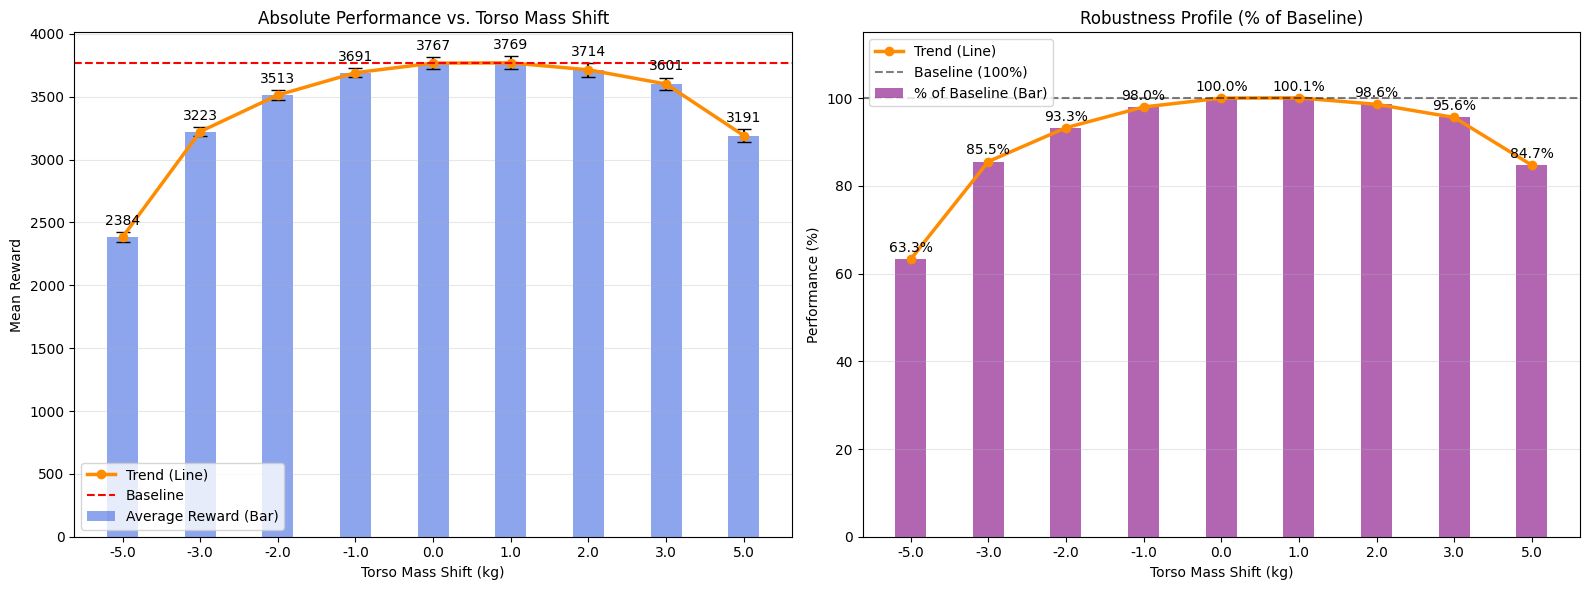

In [26]:
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# ECCO PERCHE' STATISTICHE NON CORRISPONDONO

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH ---
# Definisci i path una volta sola all'inizio
BASE_RESULTS_PATH = "./logs/halfcheetah/udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# --- 2. CARICAMENTO MODELLO ---
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

# --- 3. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,  # PORTATO A 1000 per coerenza
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.")
except:
    pass

# --- 4. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-5.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 5. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base con lo shift specifico
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug immediato della massa reale
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Vettorizzazione (necessaria per VecNormalize)
    env = DummyVecEnv([lambda: raw_env])
    
    # CARICAMENTO UNICO DELLA NORMALIZZAZIONE
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True     # <--- FONDAMENTALE per non avere reward a 600
        env.norm_reward = False 
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"\n[DEBUG] Shift richiesto: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Shift {shift:+.1f} kg | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 6. PREPARAZIONE DATI PER PLOT ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)
if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

## Friction Robustness Test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH ---
BASE_RESULTS_PATH = "./logs/halfcheetah/udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# --- 2. CARICAMENTO MODELLO ---
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

# --- 3. REGISTRAZIONE ENVIRONMENT CON FRICTION ---
try:
    register(
        id="CustomHalfCheetah-friction-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "friction", "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-friction-v0' registrato correttamente.")
except:
    pass

# --- 4. CONFIGURAZIONE VALUTAZIONE ---
# Test con variazioni di attrito (valori tipici: 0.4 default in MuJoCo)
# Testiamo da -0.3 a +0.3 (quindi da 0.1 a 0.7)
friction_shifts = [-0.3, -0.2, -0.15, -0.1, -0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.3]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza attrito su {len(friction_shifts)} configurazioni...")
print("-" * 60)

# --- 5. LOOP DI VALUTAZIONE ---
for shift in friction_shifts:
    # Creazione ambiente base con lo shift specifico
    raw_env = gym.make("CustomHalfCheetah-friction-v0", friction_shift=shift)
    
    # Debug attrito
    actual_friction = raw_env.unwrapped.model.geom_friction[0, 0]
    
    # Vettorizzazione
    env = DummyVecEnv([lambda e=raw_env: e])
    
    # CARICAMENTO NORMALIZZAZIONE
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True
        env.norm_reward = False 
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"\n[DEBUG] Shift richiesto: {shift:+.2f} | FRICTION REALE: {actual_friction:.4f}")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Friction shift {shift:+.2f} | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 6. PREPARAZIONE DATI PER PLOT ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)
if 0.0 in friction_shifts:
    baseline_idx = friction_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(friction_shifts))

# --- Grafico A: Performance Assoluta ---
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Floor Friction Shift (UDR)')
ax1.set_xlabel('Friction Shift')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)

# --- Grafico B: Performance Relativa ---
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline) - Friction')
ax2.set_xlabel('Friction Shift')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

# DORAEMON - Half Cheetah

## Training

In [27]:

HALF_CHEETAH_CONFIG_DORAEMON = {
    "env_id": "CustomHalfCheetah-v0",
    "algorithm": "SAC",         # o "PPO"
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,

    # DORAEMON Settings
    'use_doraemon': True,  
    'threshold_reward': 6000,    # Alzato per evitare il collasso della varianza
    'lr_param': 5*1e-3,          # Più veloce nell'adattare i parametri
    'lr_lambda': 5*1e-2,
    'min_std': 0.05,              # Maggiore sicurezza sulla varianza minima
}

model_doraemon, env_doraemon, _ = train_agent(HALF_CHEETAH_CONFIG_DORAEMON, log_dir="./logs/halfcheetah/doraemon")

--- STARTING NEW TRAINING ---
Using cpu device
Logging to ./tensorboard_logs/SAC_31
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.06e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 259      |
|    time_elapsed    | 15       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23.5    |
|    critic_loss     | 0.862    |
|    ent_coef        | 0.748    |
|    ent_coef_loss   | -2.86    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.02e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 228      |
|    time_elapsed    | 35       |
|    total_timesteps | 8000     |
| train/             |          

In [5]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


## Testing source VS target

In [28]:
# Run evaluation
# Define the raw environments
source_env = gym.make('CustomHalfCheetah-source-v0')
target_env = gym.make('CustomHalfCheetah-target-v0')

evaluate_sim2real(model_doraemon, source_env, target_env, log_dir="./logs/halfcheetah/doraemon", model_name="final")

Loaded Normalization stats from ./logs/halfcheetah/doraemon/final_vecnormalize.pkl


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



--- Evaluating on SOURCE Env (Simulation) ---
Reward: 6521.98 +/- 28.91
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 6430.19 +/- 27.14
Length: 1000.00 +/- 0.00 steps


(np.float64(6521.981143420935), np.float64(6430.189693874121))

## Render

In [ ]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/doraemon/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_doraemon_loaded = SAC.load('./logs/halfcheetah/doraemon/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_doraemon_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

Episode 1: Total Reward = 6055.45
Episode 2: Total Reward = 5985.13
Episode 3: Total Reward = 6193.54
Episode 4: Total Reward = 6105.29
Episode 5: Total Reward = 6118.62


## Generalization Graph

Caricamento modello da .\logs\halfcheetah\doraemon\final_model.zip...
Environment 'CustomHalfCheetah-shift-v0' registrato.

Avvio valutazione su 9 configurazioni...
------------------------------------------------------------
[DEBUG] Shift: -5.0 kg | MASSA REALE: 1.2502 kg


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-shift-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


-> Reward:  2650.98 +/-  50.50
[DEBUG] Shift: -3.0 kg | MASSA REALE: 3.2502 kg
-> Reward:  2966.12 +/-  33.53
[DEBUG] Shift: -2.0 kg | MASSA REALE: 4.2502 kg
-> Reward:  3084.81 +/-  24.48
[DEBUG] Shift: -1.0 kg | MASSA REALE: 5.2502 kg
-> Reward:  3142.54 +/-  22.40
[DEBUG] Shift: +0.0 kg | MASSA REALE: 6.2502 kg
-> Reward:  3186.94 +/-  19.04
[DEBUG] Shift: +1.0 kg | MASSA REALE: 7.2502 kg
-> Reward:  3170.66 +/-  14.98
[DEBUG] Shift: +2.0 kg | MASSA REALE: 8.2502 kg
-> Reward:  3134.26 +/-  27.03
[DEBUG] Shift: +3.0 kg | MASSA REALE: 9.2502 kg
-> Reward:  3083.29 +/-  26.88
[DEBUG] Shift: +5.0 kg | MASSA REALE: 11.2502 kg
-> Reward:  2967.63 +/-  29.64


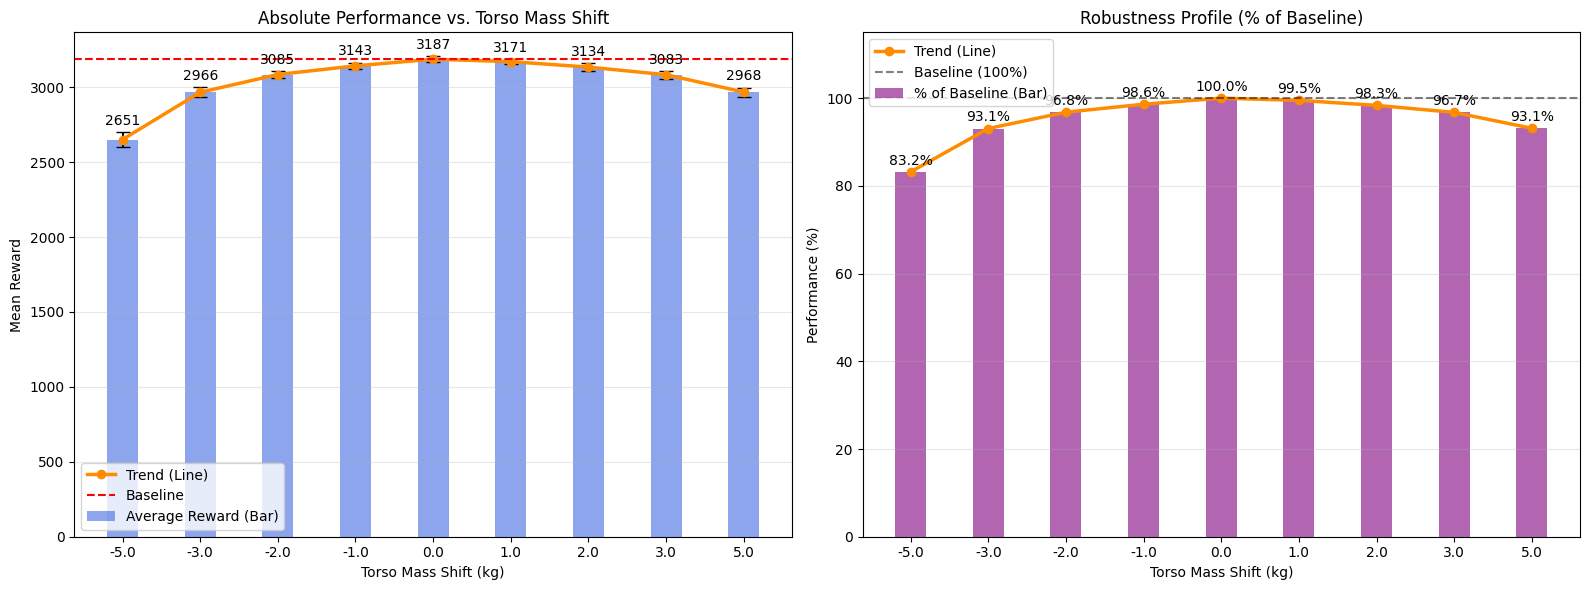

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH E CARICAMENTO ---
# Usa path consistenti
base_path = ".\\logs\\halfcheetah\\doraemon"
model_path = os.path.join(base_path, "final_model.zip")
norm_path = os.path.join(base_path, "final_vecnormalize.pkl")

print(f"Caricamento modello da {model_path}...")
model = SAC.load(model_path, device="cpu")

# --- 2. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500, # Allineato a SOURCE/TARGET
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato.")
except:
    pass

# --- 3. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-5.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0]
n_eval_episodes = 10 # Ridotto per velocità, aumenta se serve precisione
results_mean = []
results_std = []

print(f"\nAvvio valutazione su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug massa (PRIMA dei wrapper per sicurezza)
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Applicazione Wrapper Vettoriale
    env = DummyVecEnv([lambda: raw_env])
    
    # Caricamento Normalizzazione
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True    # FONDAMENTALE: Attiva la normalizzazione input
        env.norm_reward = False # Non serve normalizzare il reward in eval
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"[DEBUG] Shift: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"-> Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    env.close()

# --- 5. PLOTTING ---
# (Il tuo codice di plotting va bene, assicurati solo che results_mean sia np.array)
results_mean = np.array(results_mean)
results_std = np.array(results_std)

# ... resto del tuo codice di plotting ...

if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

## Friction Robustness Test

Caricamento modello da .\logs\halfcheetah\doraemon\final_model.zip...
Environment 'CustomHalfCheetah-friction-v0' registrato.

Avvio valutazione su 8 configurazioni...
------------------------------------------------------------
[DEBUG] Shift: -0.40 | FRICTION REALE: 0.0100


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-friction-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


-> Reward:  3192.98 +/-  19.37
[DEBUG] Shift: +0.00 | FRICTION REALE: 0.4000
-> Reward:  3186.36 +/-  13.19
[DEBUG] Shift: +0.50 | FRICTION REALE: 0.9000
-> Reward:  3172.60 +/-  12.22
[DEBUG] Shift: +1.00 | FRICTION REALE: 1.4000
-> Reward:  3050.94 +/-  17.93
[DEBUG] Shift: +1.50 | FRICTION REALE: 1.9000
-> Reward:  2382.80 +/- 313.09
[DEBUG] Shift: +2.00 | FRICTION REALE: 2.4000
-> Reward:   824.17 +/-  39.81
[DEBUG] Shift: +2.50 | FRICTION REALE: 2.9000
-> Reward:   571.36 +/-  50.19
[DEBUG] Shift: +3.00 | FRICTION REALE: 3.4000
-> Reward:   486.81 +/-  36.52


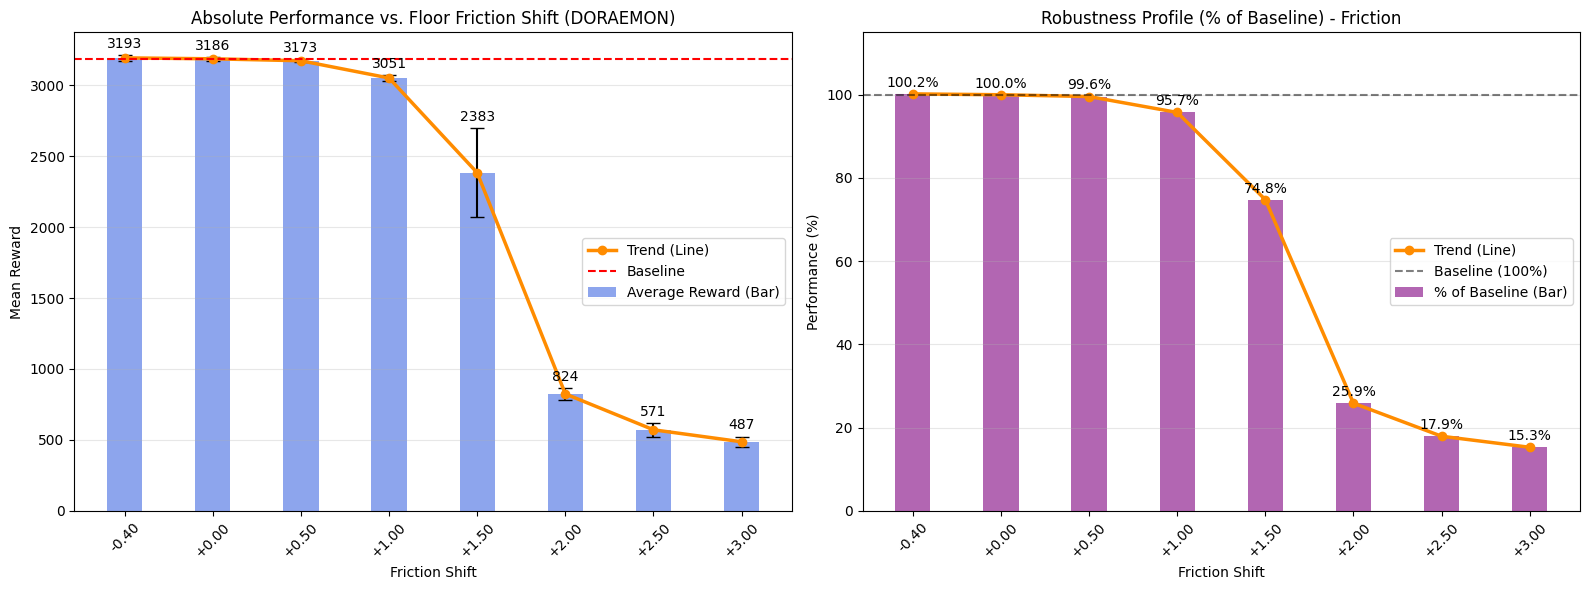

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH E CARICAMENTO ---
base_path = ".\\logs\\halfcheetah\\doraemon"
model_path = os.path.join(base_path, "final_model.zip")
norm_path = os.path.join(base_path, "final_vecnormalize.pkl")

print(f"Caricamento modello da {model_path}...")
model = SAC.load(model_path, device="cpu")

# --- 2. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-friction-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "friction", "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-friction-v0' registrato.")
except:
    pass

# --- 3. CONFIGURAZIONE VALUTAZIONE ---
# sul ghiaccio
friction_shifts = [-0.4, 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
n_eval_episodes = 10
results_mean = []
results_std = []

print(f"\nAvvio valutazione su {len(friction_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in friction_shifts:
    # Creazione ambiente base
    raw_env = gym.make("CustomHalfCheetah-friction-v0", friction_shift=shift)
    
    # Debug attrito
    actual_friction = raw_env.unwrapped.model.geom_friction[0, 0]
    
    # Applicazione Wrapper Vettoriale
    env = DummyVecEnv([lambda e=raw_env: e])
    
    # Caricamento Normalizzazione
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True
        env.norm_reward = False
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"[DEBUG] Shift: {shift:+.2f} | FRICTION REALE: {actual_friction:.4f}")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"-> Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    env.close()

# --- 5. PLOTTING ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)

if 0.0 in friction_shifts:
    baseline_idx = friction_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(friction_shifts))

# --- Grafico A: Performance Assoluta ---
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Floor Friction Shift (DORAEMON)')
ax1.set_xlabel('Friction Shift')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)

# --- Grafico B: Performance Relativa ---
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline) - Friction')
ax2.set_xlabel('Friction Shift')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()